<h1> Practica de Datos espaciales con datos de la evaluacion</h1>

In [6]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import libpysal.weights as weights

from libpysal.weights import DistanceBand
from esda.moran import Moran, Moran_Local
from IPython.display import display
from spreg import ML_Lag

<h2>Variables</h2>
<li>house.price: precio de la vivienda (euro/m2) 
<li>historical: indica si una vivienda pertenece o no al casco histórico de Madrid
<li>longitude: longitud en coordenadas geográficas 
<li>latitude: latitud en coordenadas geográficas

Variable objetivo: house.price
Variables predictoras: longitude, latitude, historical

<h2>Medicion de la autocorrelacion</h2>

In [7]:
# Cargar los datos
data = pd.read_csv("Data_Housing_Madrid.csv")

# Filtrar propiedades del centro histórico
centro_historico = data[data['historical'] == 1].copy()

# Calcular precio por metro cuadrado
centro_historico['price_per_sqm'] = centro_historico['house.price'] / centro_historico['built.area']

# Crear GeoDataFrame usando las coordenadas
geometry = gpd.points_from_xy(centro_historico['longitude'], centro_historico['latitude'])
gdf = gpd.GeoDataFrame(centro_historico, geometry=geometry, crs="EPSG:4326")
print(gdf.crs) 
# Convertir a un sistema de coordenadas proyectado (metros)
gdf = gdf.to_crs("EPSG:25830")  # ETRS89 / UTM zone 30N

EPSG:4326


In [8]:
coords = list(zip(gdf.geometry.x, gdf.geometry.y))
w_distance = DistanceBand(coords, threshold=300, binary=True)

c:\Users\pablo\anaconda3\envs\master_ucm_spatial_data\lib\site-packages\libpysal\weights\weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 110 disconnected components.
 There are 86 islands with ids: 8, 38, 136, 139, 160, 319, 342, 380, 412, 426, 438, 464, 567, 623, 710, 720, 726, 728, 842, 898, 938, 1056, 1073, 1141, 1161, 1193, 1201, 1266, 1289, 1302, 1337, 1427, 1432, 1454, 1458, 1467, 1484, 1528, 1622, 1645, 1660, 1678, 1687, 1745, 1870, 1882, 1891, 1901, 2028, 2085, 2091, 2102, 2131, 2190, 2205, 2260, 2430, 2445, 2504, 2511, 2625, 2681, 2719, 2732, 2813, 2878, 3015, 3024, 3075, 3099, 3171, 3182, 3212, 3270, 3330, 3382, 3389, 3418, 3481, 3490, 3513, 3555, 3559, 3566, 3610, 3625.
  warnings.warn(message)


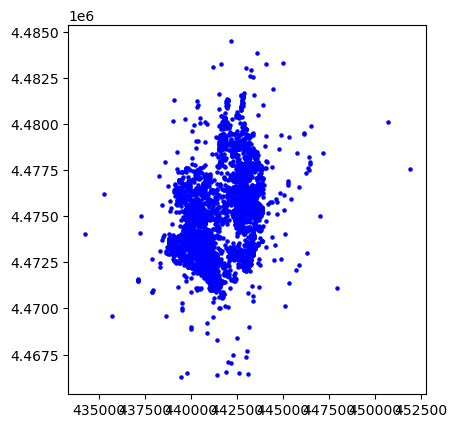

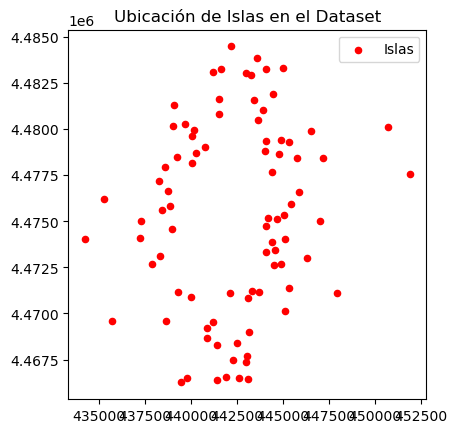

In [9]:
islas = np.where(w_distance.sparse.sum(axis=1).A1 == 0)[0]
# Graficar todas las observaciones
gdf.plot(color='blue', markersize=5, label='Datos')

# Resaltar islas
gdf.iloc[islas].plot(color='red', markersize=20, label='Islas')

plt.title("Ubicación de Islas en el Dataset")
plt.legend()
plt.show()

Debido a el alto numero de vecinos con threshold bastante alto voy a proceder a usar un enfoque de k veciones proximos

In [10]:
for k in [5, 10, 15]:
    w_temp = weights.KNN.from_dataframe(gdf, k=k)
    moran_temp = Moran(gdf['price_per_sqm'], w_temp)
    print(f"k={k}: I={moran_temp.I:.3f}, p={moran_temp.p_norm:.3f}")

k=5: I=0.152, p=0.000
k=10: I=0.124, p=0.000
k=15: I=0.114, p=0.000


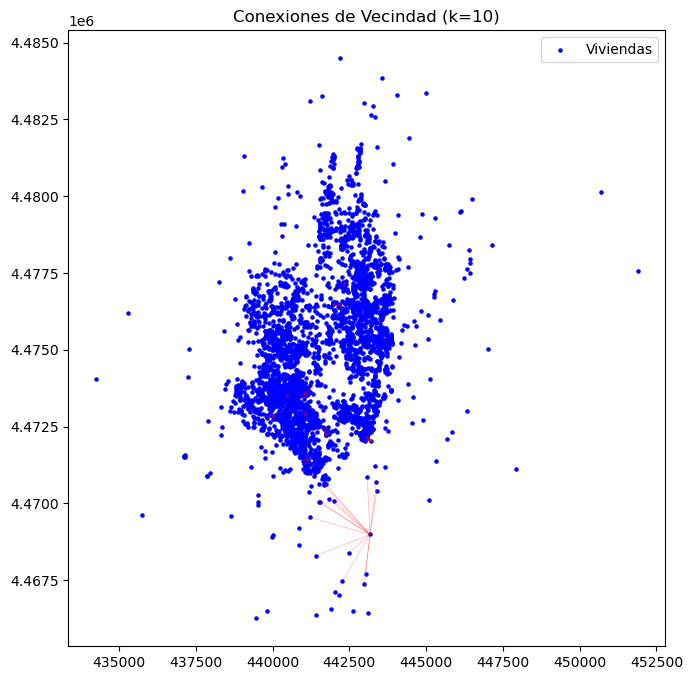

In [11]:
# Resetear índices de gdf (si no afecta otros análisis)
gdf.reset_index(drop=True, inplace=True)

# Recrear w_knn y coords
w_knn = weights.KNN.from_dataframe(gdf, k=15)
coords = list(zip(gdf.geometry.x, gdf.geometry.y))

# Graficar
plt.figure(figsize=(10, 8))
gdf.plot(ax=plt.gca(), color='blue', markersize=5, label='Viviendas')

for i in list(w_knn.neighbors.keys())[:10]:
    origin = coords[i]
    for neighbor in w_knn.neighbors[i]:
        if neighbor < len(coords):  # Validación adicional
            destination = coords[neighbor]
            plt.plot([origin[0], destination[0]], [origin[1], destination[1]], 
                    color='red', linewidth=0.5, alpha=0.3)

plt.title("Conexiones de Vecindad (k=10)")
plt.legend()
plt.show()

Vamos a verificar si es que la autocorreelcion espacial es significativa con diferentes k proximos para ver cual numero de vecinos representa un indice de autocorrelacion superior

In [12]:
for k in [5, 10, 15]:
    w_temp = weights.KNN.from_dataframe(gdf, k=k)
    moran_temp = Moran(gdf['price_per_sqm'], w_temp)
    print(f"k={k}: I={moran_temp.I:.3f}, p={moran_temp.p_norm:.3f}")

k=5: I=0.152, p=0.000
k=10: I=0.124, p=0.000
k=15: I=0.114, p=0.000


In [13]:
# Calcular LISA
lisa_knn = Moran_Local(gdf['price_per_sqm'], w_knn)

# Identificar clusters significativos (p < 0.05)
hotspots = (lisa_knn.q == 1) & (lisa_knn.p_sim < 0.05)
coldspots = (lisa_knn.q == 3) & (lisa_knn.p_sim < 0.05)

print(f"Hotspots (Alto-Alto): {sum(hotspots)}")
print(f"Coldspots (Bajo-Bajo): {sum(coldspots)}")


Hotspots (Alto-Alto): 281
Coldspots (Bajo-Bajo): 462


In [14]:
# Suponiendo que ya tienes el objeto `lisa_knn` y has asignado los clusters
gdf['lisa_cluster'] = 'No significativo'
gdf.loc[(lisa_knn.q == 1) & (lisa_knn.p_sim < 0.05), 'lisa_cluster'] = 'Alto-Alto'
gdf.loc[(lisa_knn.q == 2) & (lisa_knn.p_sim < 0.05), 'lisa_cluster'] = 'Bajo-Bajo'
gdf.loc[(lisa_knn.q == 3) & (lisa_knn.p_sim < 0.05), 'lisa_cluster'] = 'Alto-Bajo'
gdf.loc[(lisa_knn.q == 4) & (lisa_knn.p_sim < 0.05), 'lisa_cluster'] = 'Bajo-Alto'

# Crear tabla de conteo
tabla_conteo = gdf['lisa_cluster'].value_counts().reset_index()
tabla_conteo.columns = ['Cluster LISA', 'Número de Observaciones']
tabla_conteo['Porcentaje'] = (tabla_conteo['Número de Observaciones'] / len(gdf)) * 100


# Formatear la tabla para mejor visualización
tabla_formateada = tabla_conteo.copy()
tabla_formateada['Porcentaje'] = tabla_formateada['Porcentaje'].round(2).astype(str) + ' %'

display(tabla_formateada)

,Cluster LISA,Número de Observaciones,Porcentaje
0,No significativo,2587,71.21 %
1,Alto-Bajo,462,12.72 %
2,Alto-Alto,281,7.73 %
3,Bajo-Bajo,214,5.89 %
4,Bajo-Alto,89,2.45 %


<h3>LISA con matriz de pesos con distancias (asumiendo elevado numero de islas)</h3>

In [15]:
w_distance = DistanceBand(coords, threshold=500, binary=True)
# Calcular LISA
lisa_distance = Moran_Local(gdf['price_per_sqm'], w_distance)

# Identificar clusters significativos (p < 0.05)
hotspots = (lisa_distance.q == 1) & (lisa_distance.p_sim < 0.05)
coldspots = (lisa_distance.q == 3) & (lisa_distance.p_sim < 0.05)

print(f"Hotspots (Alto-Alto): {sum(hotspots)}")
print(f"Coldspots (Bajo-Bajo): {sum(coldspots)}")


# Suponiendo que ya tienes el objeto `lisa_distance` y has asignado los clusters
gdf['lisa_cluster'] = 'No significativo'
gdf.loc[(lisa_distance.q == 1) & (lisa_distance.p_sim < 0.05), 'lisa_cluster'] = 'Alto-Alto'
gdf.loc[(lisa_distance.q == 2) & (lisa_distance.p_sim < 0.05), 'lisa_cluster'] = 'Bajo-Bajo'
gdf.loc[(lisa_distance.q == 3) & (lisa_distance.p_sim < 0.05), 'lisa_cluster'] = 'Alto-Bajo'
gdf.loc[(lisa_distance.q == 4) & (lisa_distance.p_sim < 0.05), 'lisa_cluster'] = 'Bajo-Alto'

# Crear tabla de conteo
tabla_conteo = gdf['lisa_cluster'].value_counts().reset_index()
tabla_conteo.columns = ['Cluster LISA', 'Número de Observaciones']
tabla_conteo['Porcentaje'] = (tabla_conteo['Número de Observaciones'] / len(gdf)) * 100


# Formatear la tabla para mejor visualización
tabla_formateada = tabla_conteo.copy()
tabla_formateada['Porcentaje'] = tabla_formateada['Porcentaje'].round(2).astype(str) + ' %'

display(tabla_formateada)

c:\Users\pablo\anaconda3\envs\master_ucm_spatial_data\lib\site-packages\libpysal\weights\weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 68 disconnected components.
 There are 45 islands with ids: 8, 38, 136, 412, 464, 726, 728, 842, 938, 1073, 1161, 1289, 1302, 1337, 1427, 1458, 1467, 1622, 1660, 1678, 1870, 1882, 1901, 2091, 2102, 2131, 2190, 2205, 2260, 2445, 2504, 2681, 2732, 3015, 3075, 3171, 3212, 3330, 3389, 3418, 3481, 3490, 3513, 3555, 3559.
  warnings.warn(message)


('WARNING: ', 8, ' is an island (no neighbors)')
('WARNING: ', 38, ' is an island (no neighbors)')
('WARNING: ', 136, ' is an island (no neighbors)')
('WARNING: ', 412, ' is an island (no neighbors)')
('WARNING: ', 464, ' is an island (no neighbors)')
('WARNING: ', 726, ' is an island (no neighbors)')
('WARNING: ', 728, ' is an island (no neighbors)')
('WARNING: ', 842, ' is an island (no neighbors)')
('WARNING: ', 938, ' is an island (no neighbors)')
('WARNING: ', 1073, ' is an island (no neighbors)')
('WARNING: ', 1161, ' is an island (no neighbors)')
('WARNING: ', 1289, ' is an island (no neighbors)')
('WARNING: ', 1302, ' is an island (no neighbors)')
('WARNING: ', 1337, ' is an island (no neighbors)')
('WARNING: ', 1427, ' is an island (no neighbors)')
('WARNING: ', 1458, ' is an island (no neighbors)')
('WARNING: ', 1467, ' is an island (no neighbors)')
('WARNING: ', 1622, ' is an island (no neighbors)')
('WARNING: ', 1660, ' is an island (no neighbors)')
('WARNING: ', 1678, ' is

c:\Users\pablo\anaconda3\envs\master_ucm_spatial_data\lib\site-packages\esda\moran.py:1057: RuntimeWarning: invalid value encountered in true_divide
  self.z_sim = (self.Is - self.EI_sim) / self.seI_sim


,Cluster LISA,Número de Observaciones,Porcentaje
0,No significativo,1998,55.0 %
1,Alto-Bajo,586,16.13 %
2,Alto-Alto,460,12.66 %
3,Bajo-Bajo,416,11.45 %
4,Bajo-Alto,173,4.76 %


El uso de las distancias en vez de los k proximos nos muestra para el calculo de los clustes locales con la tecnica LISA nos indica que los patrones de correlacion de las agrupaciones de datos en ciertas regiones con el precio de la vivienda funciona mejor con la matriz de pesos con la vecindad determinada por las distancias entra las viviendas que con los k vecinos proximos aunque asumamos la perdidad de informacion por las islas presentes en la matriz por distancias

<h2>Modelo de regresion espacial</h2>

In [21]:
# Definir variables correctamente
y = gdf['price_per_sqm'].values  # Convertir Series a numpy array
X = gdf[['historical']].values   # DataFrame a numpy array (ya usaste .values aquí)

# Ajustar modelo SAR
model = ML_Lag(y, X, w=w_distance, name_y='price_per_sqm', name_x=['historical'])
print(model.summary)

c:\Users\pablo\anaconda3\envs\master_ucm_spatial_data\lib\site-packages\scipy\optimize\_minimize.py:784: RuntimeWarning: Method 'bounded' does not support relative tolerance in x; defaulting to absolute tolerance.
  "defaulting to absolute tolerance.", RuntimeWarning)


REGRESSION
----------
SUMMARY OF OUTPUT: MAXIMUM LIKELIHOOD SPATIAL LAG (METHOD = FULL)
-----------------------------------------------------------------
Data set            :     unknown
Weights matrix      :     unknown
Dependent Variable  :price_per_sqm                Number of Observations:        3633
Mean dependent var  :     60.8850                Number of Variables   :           2
S.D. dependent var  :     40.8091                Degrees of Freedom    :        3631
Pseudo R-squared    :      0.0413
Spatial Pseudo R-squared:  0.0002
Sigma-square ML     :    1599.513                Log likelihood        :  -18567.851
S.E of regression   :      39.994                Akaike info criterion :   37139.702
                                                 Schwarz criterion     :   37152.097

------------------------------------------------------------------------------------
            Variable     Coefficient       Std.Error     z-Statistic     Probability
----------------------------

<h3>Conclusiones</h3> 

el pseudo r2 espacial es malisismo a pesar de que el peso de que la I de Moran es bastante buena. Evidentemenete la mera ubicacion geografica no alcanza para calcular el costo del metro cuadrado en el centro historico de madrid.

Conclusiones de deepseek:

Analizando los resultados de tu modelo SAR (Spatial Autoregressive), puedo extraer las siguientes conclusiones:

1. Problema con la variable independiente:
El modelo ha eliminado tu variable historical por ser constante (siempre tiene el mismo valor para todas las observaciones). Esto explica por qué en los resultados solo aparece la constante y el término espacial.

Implicación: No estás modelando realmente ninguna relación con variables explicativas, solo un efecto espacial puro.

2. Significancia del efecto espacial:
El coeficiente W_price_per_sqm (ρ) es 0.449 y altamente significativo (p-value = 0.000).

Interpretación: Existe una fuerte dependencia espacial positiva - el precio por m² de una vivienda tiende a ser más alto cuando los precios de las viviendas cercanas son altos.

3. Bajo poder explicativo:
El Pseudo R² es muy bajo (0.0413), indicando que el modelo explica solo el 4.13% de la variación.

El Spatial Pseudo R² es casi cero (0.0002), sugiriendo que el componente espacial no aporta mucho poder explicativo adicional.

4. Ajuste general del modelo:
El valor alto de Sigma-square ML (1599.513) y S.E. of regression (39.994) indican que los residuales son grandes en relación con la media de la variable dependiente (60.8850).

Recomendaciones para mejorar el modelo:
Incluir variables explicativas relevantes:

python
Copy
X = gdf[['built.area', 'age', 'baths', 'crime', 'retired']].values
name_x = ['built.area', 'age', 'baths', 'crime', 'retired']
Verificar multicolinealidad:

python
Copy
from statsmodels.stats.outliers_influence import variance_inflation_factor
vif = [variance_inflation_factor(X, i) for i in range(X.shape[1])]
Probar diferentes matrices de pesos espaciales:

python
Copy
from libpysal.weights import DistanceBand
w_dist = DistanceBand.from_dataframe(gdf, threshold=1000) # ajusta el umbral
Considerar modelos alternativos:

Si el efecto espacial es principalmente en los errores, un modelo SEM (Spatial Error) podría ser más apropiado.

Transformar variables:

Prueba con logaritmos de variables continuas para normalizar distribuciones:

python
Copy
gdf['log_price'] = np.log(gdf['price_per_sqm'])
El modelo actual tiene limitaciones importantes debido a la falta de variables explicativas significativas. El efecto espacial es fuerte pero el modelo no captura adecuadamente los factores que determinan los precios.